#**Importation of Libraries and Dataset**

In [17]:
#install pandas library
!pip install pandas scikit-learn transformers torch tqdm
!pip install transformers



In [18]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, GPT2Tokenizer, GPT2ForSequenceClassification
from transformers import T5Tokenizer, T5ForSequenceClassification
from transformers import pipeline
import torch
from tqdm import tqdm

In [19]:
# Load the IMDB dataset
data_path = os.path.expanduser("/content/IMDB Dataset.csv")
df = pd.read_csv(data_path)
df=df.sample(n=10000, random_state=42) #randomly extract 10,000 samples for this analysis

#**Data Extraction and Cleaning**

In [20]:
#view the first five rows of the dataset
df.head()

,review,sentiment
33553,I really liked this Summerslam due to the look...,positive
9427,Not many television shows appeal to quite as m...,positive
199,The film quickly gets to a major chase scene w...,negative
12447,Jane Austen would definitely approve of this o...,positive
39489,Expectations were somewhat high for me when I ...,negative


In [21]:
#disply the shape of the data
df.shape

(10000, 2)

In [22]:
#encoding the sentiment column to integer
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df.head()

,review,sentiment
33553,I really liked this Summerslam due to the look...,1
9427,Not many television shows appeal to quite as m...,1
199,The film quickly gets to a major chase scene w...,0
12447,Jane Austen would definitely approve of this o...,1
39489,Expectations were somewhat high for me when I ...,0


In [23]:
#Remove punctuation using string module
df['review'] =df['review'].apply(lambda x: ''.join(i for i in x if i not in string.punctuation))

In [24]:
#Convert to lowercase
df['review'] = df['review'].str.lower()

In [25]:
#Remove stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
allstopwords = stopwords.words('english')
df['review']= df.review.apply(lambda x: " ".join(i for i in x.split() if i not in allstopwords))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
# This code cleans and processes reviews from a DataFrame:
# 1. Removes non-alphabetic characters.
# 2. Splits and rejoins the cleaned text.
# 3. Stores processed reviews in a list (corpus).
corpus=[]

# Iterate through the DataFrame using .iterrows()
for index, row in df.iterrows():
    review=re.sub('[^a-zA-Z]', " ", row['review']) # Access review using row['review']
    review=review.split()
    review= " ".join(review)
    corpus.append(review)

In [27]:
df.head()

,review,sentiment
33553,really liked summerslam due look arena curtain...,1
9427,many television shows appeal quite many differ...,1
199,film quickly gets major chase scene ever incre...,0
12447,jane austen would definitely approve onebr br ...,1
39489,expectations somewhat high went see movie thou...,0


In [28]:
null_values = df.isnull().sum() #identifying missing values
null_values.index[0]
print('There are {} missing values for {} and {} missing values for {}.'.format(null_values[0],null_values.index[0],null_values[1],null_values.index[1]))

There are 0 missing values for review and 0 missing values for sentiment.


<ipython-input-28-23b00bc3ccf7>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('There are {} missing values for {} and {} missing values for {}.'.format(null_values[0],null_values.index[0],null_values[1],null_values.index[1]))


#**Exploratory Data Analysis**

<ipython-input-29-65ada1f51082>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="sentiment", data=df, palette={'1': 'green', '0': 'red'}, order=['1', '0'])


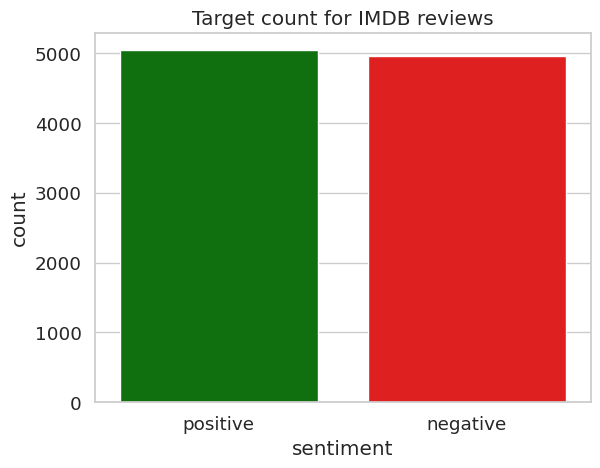

In [29]:
#Count Plot
sns.set(style="whitegrid", font_scale=1.2)
sns.countplot(x="sentiment", data=df, palette={'1': 'green', '0': 'red'}, order=['1', '0'])
plt.xticks(ticks=np.arange(2), labels=['positive', 'negative'])
plt.title('Target count for IMDB reviews')
plt.show()


In [30]:
# Display the distribution of the sentiment in percentage
positive_count = df['sentiment'].value_counts()[1]  # Number of positive reviews
negative_count = df['sentiment'].value_counts()[0]  # Number of negative reviews
total_count = len(df)  # Total number of reviews

# Calculate percentages
positive_percentage = round((positive_count / total_count) * 100, 2)
negative_percentage = round((negative_count / total_count) * 100, 2)

# Print results
print(f'Positive reviews are {positive_count}, i.e., {positive_percentage}% of the dataset.')
print(f'Negative reviews are {negative_count}, i.e., {negative_percentage}% of the dataset.')


Positive reviews are 5039, i.e., 50.39% of the dataset.
Negative reviews are 4961, i.e., 49.61% of the dataset.


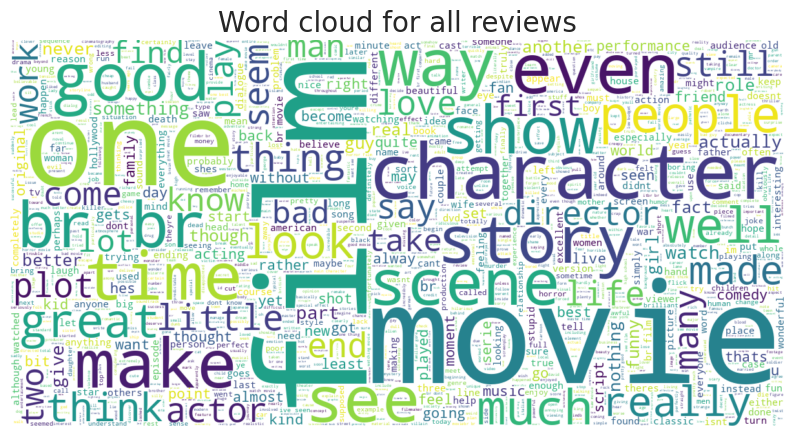

In [31]:
# Word cloud for all reviews

all_data = df['review']  # Use all reviews regardless of sentiment
all_data_string = ' '.join(all_data)  # Combine all reviews into a single string
plt.figure(figsize=(10, 10))  # Set the figure size
wc = WordCloud(max_words=2000, width=1200, height=600, background_color="white").generate(all_data_string)
plt.imshow(wc, interpolation='bilinear')  # Display the word cloud
plt.axis('off')  # Remove axes
plt.title('Word cloud for all reviews', fontsize=20)  # Add title
plt.show()  # Show the plot


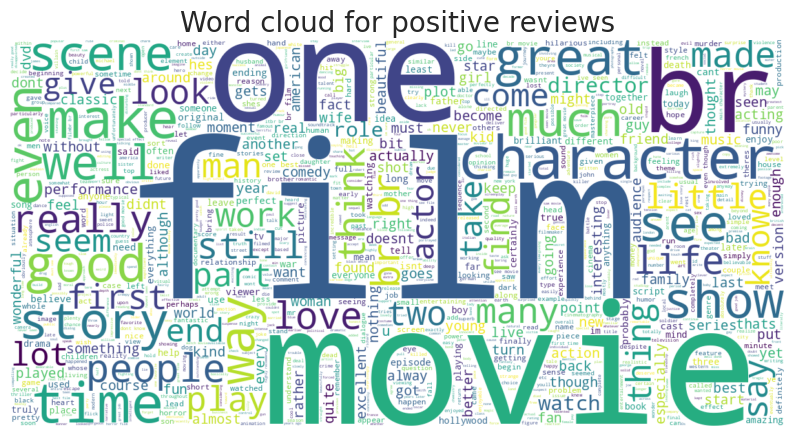

In [32]:
#word cloud for positive reviews
from wordcloud import WordCloud
positive_data = df[df.sentiment == 1]['review']
positive_data_string = ' '.join(positive_data)
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(positive_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for positive reviews',fontsize = 20)
plt.show()

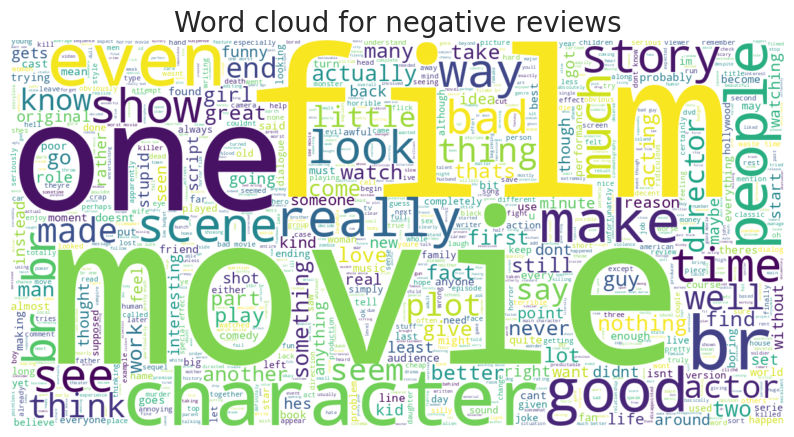

In [33]:
#word cloud for negative reviews
negative_data = df[df.sentiment == 0]['review']
negative_data_string = ' '.join(negative_data)
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(negative_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for negative reviews',fontsize = 20)
plt.show()

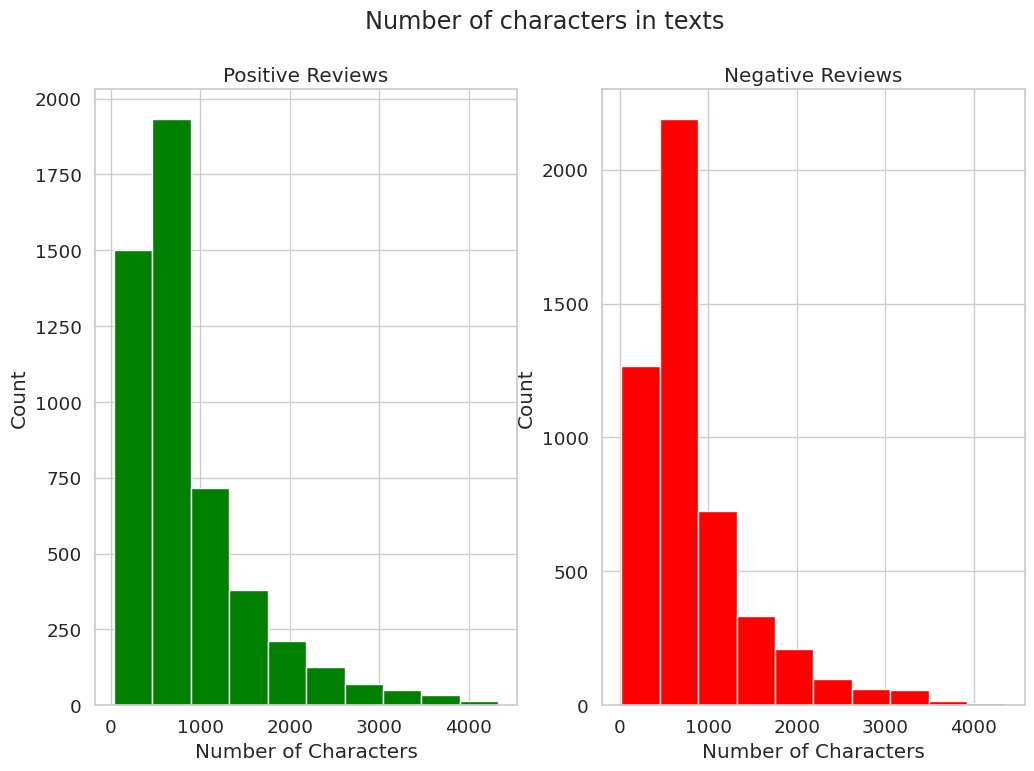

In [34]:
#display of number of characters in texts
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=positive_data.str.len()
ax1.hist(text_len,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of Characters')
ax1.set_ylabel('Count')
text_len=negative_data.str.len()
ax2.hist(text_len,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of Characters')
ax2.set_ylabel('Count')
fig.suptitle('Number of characters in texts')
plt.show()



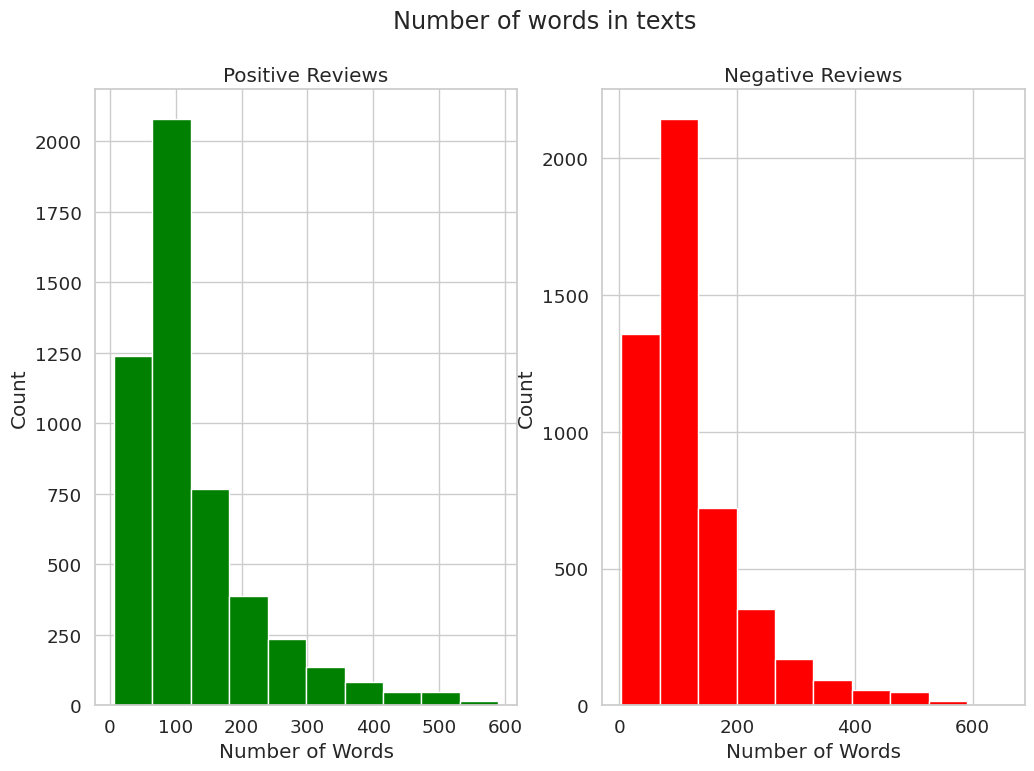

In [35]:
#plot to show number of words in texts
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=positive_data.str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Count')
text_len=negative_data.str.split().map(lambda x: len(x))
ax2.hist(text_len,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Count')
fig.suptitle('Number of words in texts')
plt.show()

<ipython-input-36-551996c06bd6>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word, ax=ax1,color='green')
<ipython-input-36-551996c06bd6>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word,ax=ax2,color='red')


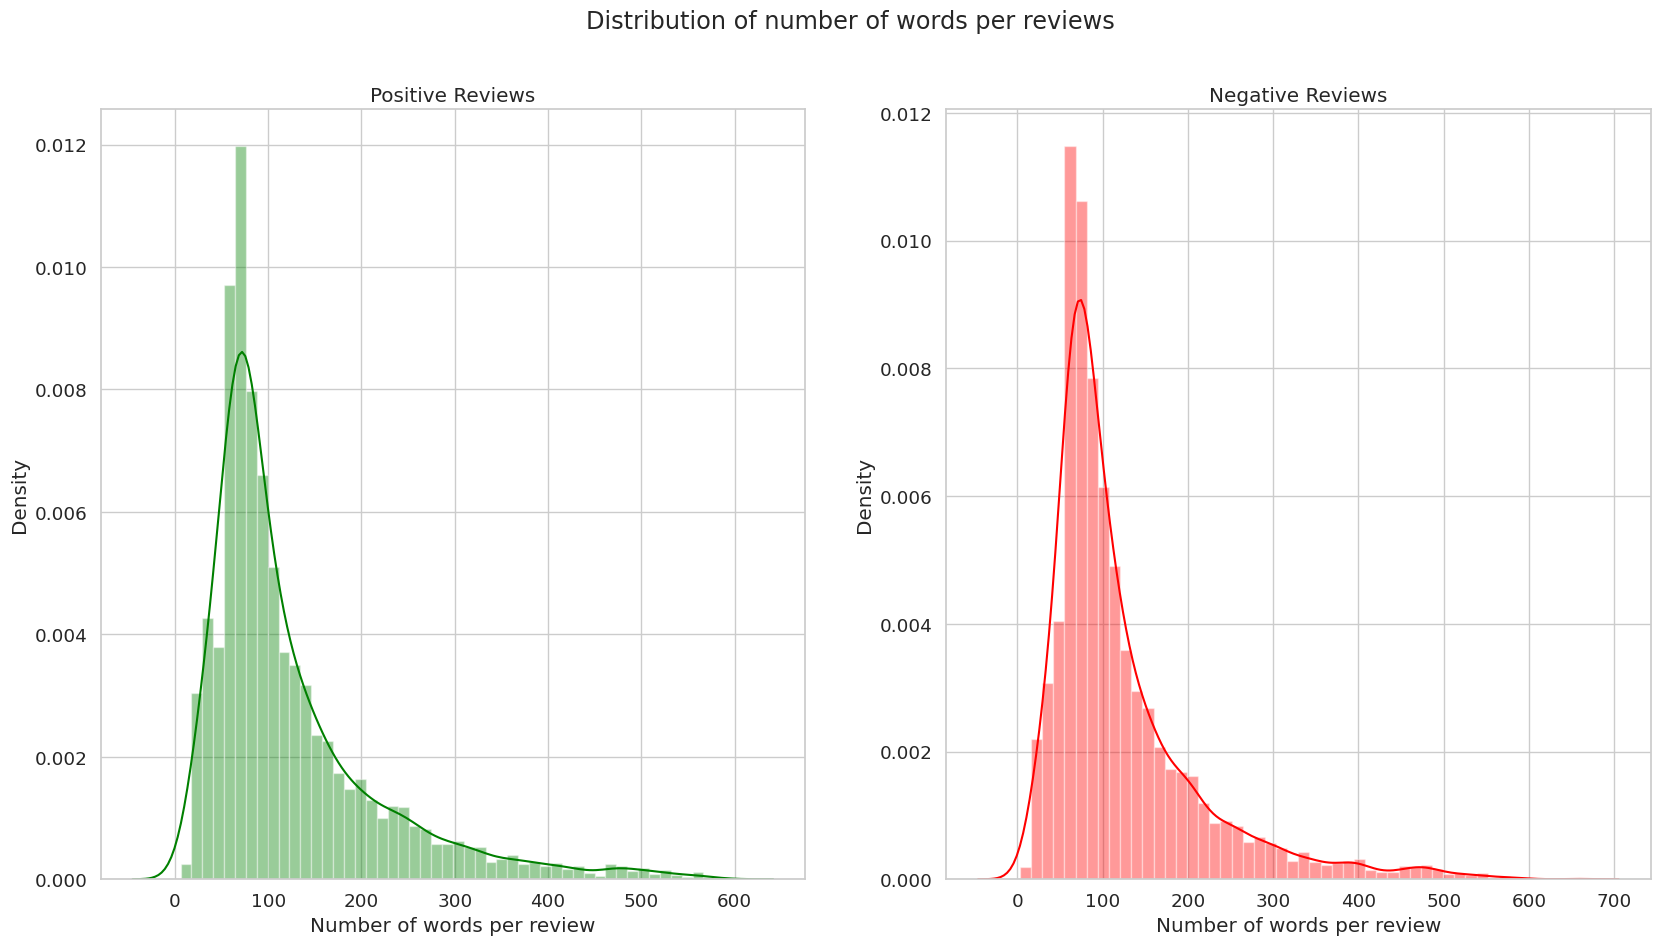

In [36]:
#plot to show distribution of words per review
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word = positive_data.str.split().apply(lambda x : len(x) )
sns.distplot(word, ax=ax1,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of words per review')
word = negative_data.str.split().apply(lambda x :len(x) )
sns.distplot(word,ax=ax2,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of words per review')
fig.suptitle('Distribution of number of words per reviews')
plt.show()

<ipython-input-37-525fb8d946da>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1,color='green')
<ipython-input-37-525fb8d946da>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')


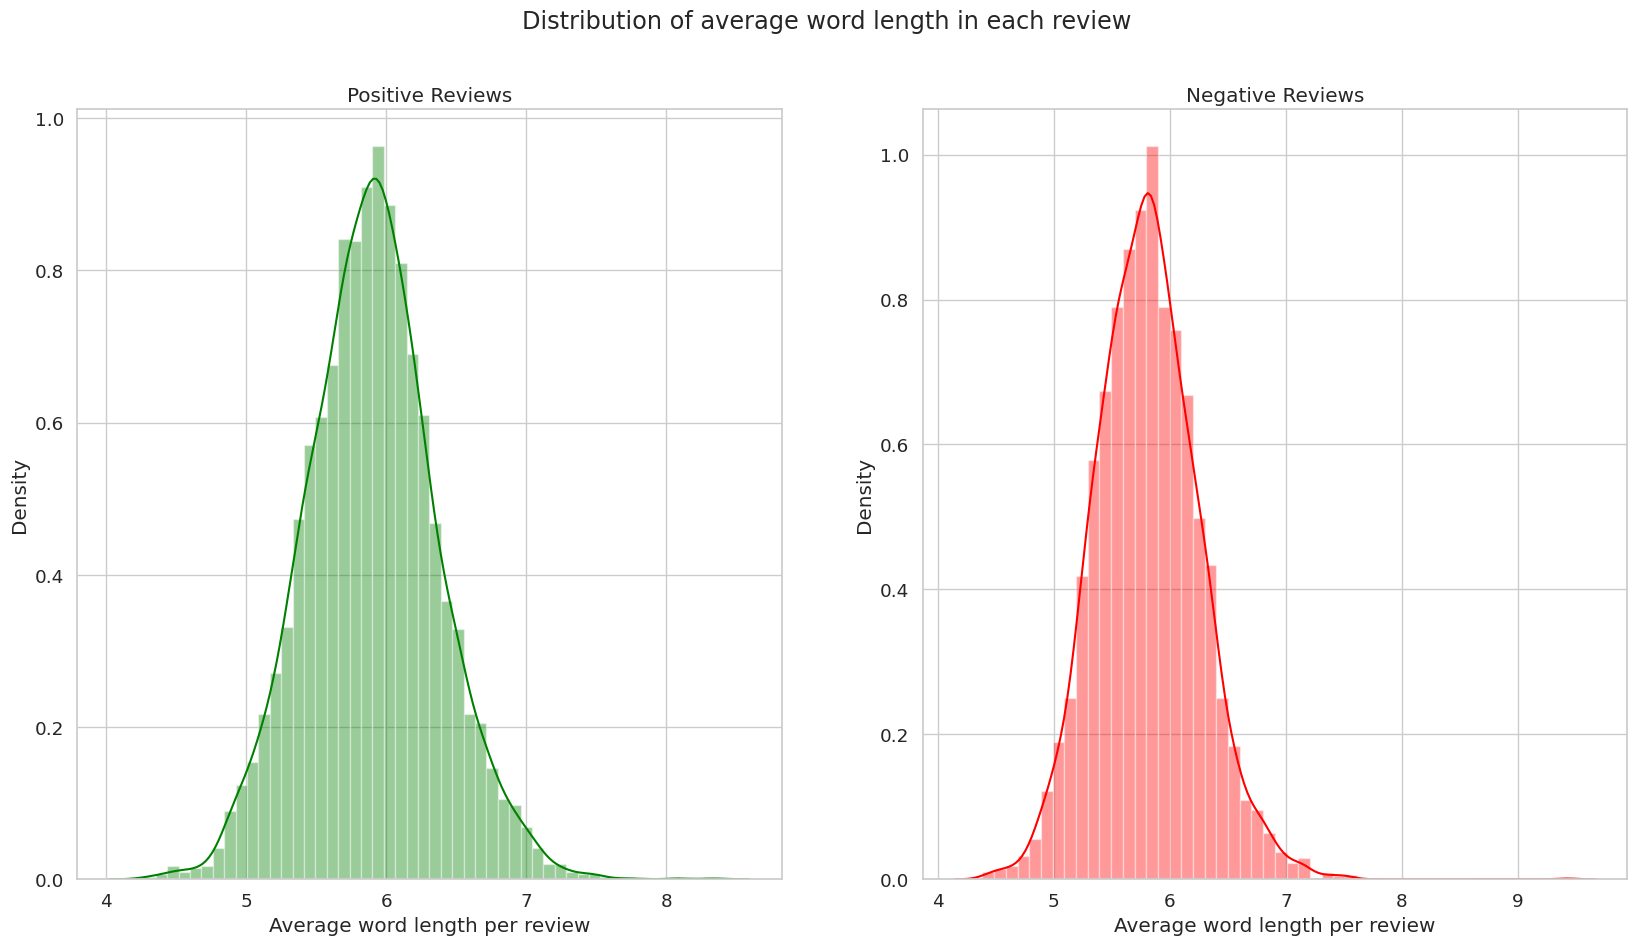

In [37]:
#plot to show distrubution of average word length
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word = positive_data.str.split().apply(lambda x : [len(i) for i in x] )
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Average word length per review')
word = negative_data.str.split().apply(lambda x : [len(i) for i in x] )
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Average word length per review')
fig.suptitle('Distribution of average word length in each review')
plt.show()

In [38]:
#return words as a corpus
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.review)
corpus[:5]

['really', 'liked', 'summerslam', 'due', 'look']

In [39]:
#Display words most occuring in counts
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = pd.DataFrame(most_common,columns = ['corpus','countv'])
most_common

,corpus,countv
0,br,22647
1,movie,16910
2,film,14802
3,one,10113
4,like,7837
5,good,5810
6,even,4975
7,would,4782
8,time,4630
9,really,4619


In [40]:
most_common = most_common.sort_values('countv')

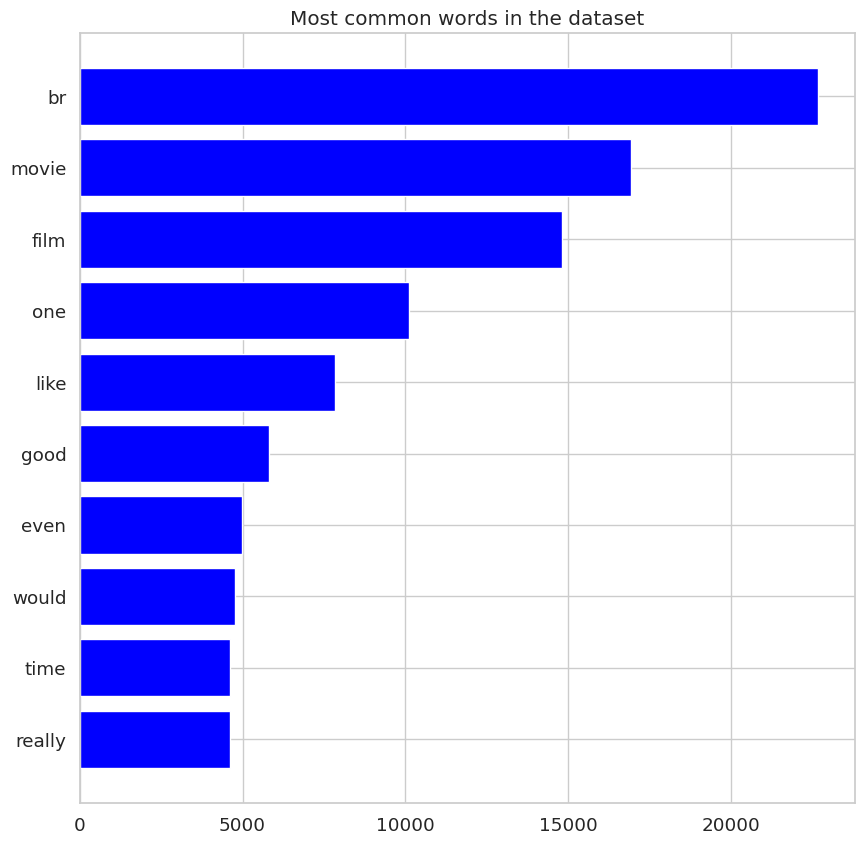

In [41]:
#display showing most occuring words in a bar chart
plt.figure(figsize =(10,10))
plt.yticks(range(len(most_common)), list(most_common.corpus))
plt.barh(range(len(most_common)), list(most_common.countv),align='center',color = 'blue')
plt.title('Most common words in the dataset')
plt.show()

In [42]:
#text vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
def get_ngrams(review, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(review)
    bag_of_words = vec.transform(review) #sparse matrix of count_vectorizer
    sum_words = bag_of_words.sum(axis=0) #total number of words
    sum_words = np.array(sum_words)[0].tolist() #convert to list
    words_freq = [(word, sum_words[idx]) for word, idx in vec.vocabulary_.items()] #get word freqency for word location in count vec
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) #key is used to perform sorting using word_freqency
    return words_freq[:n]

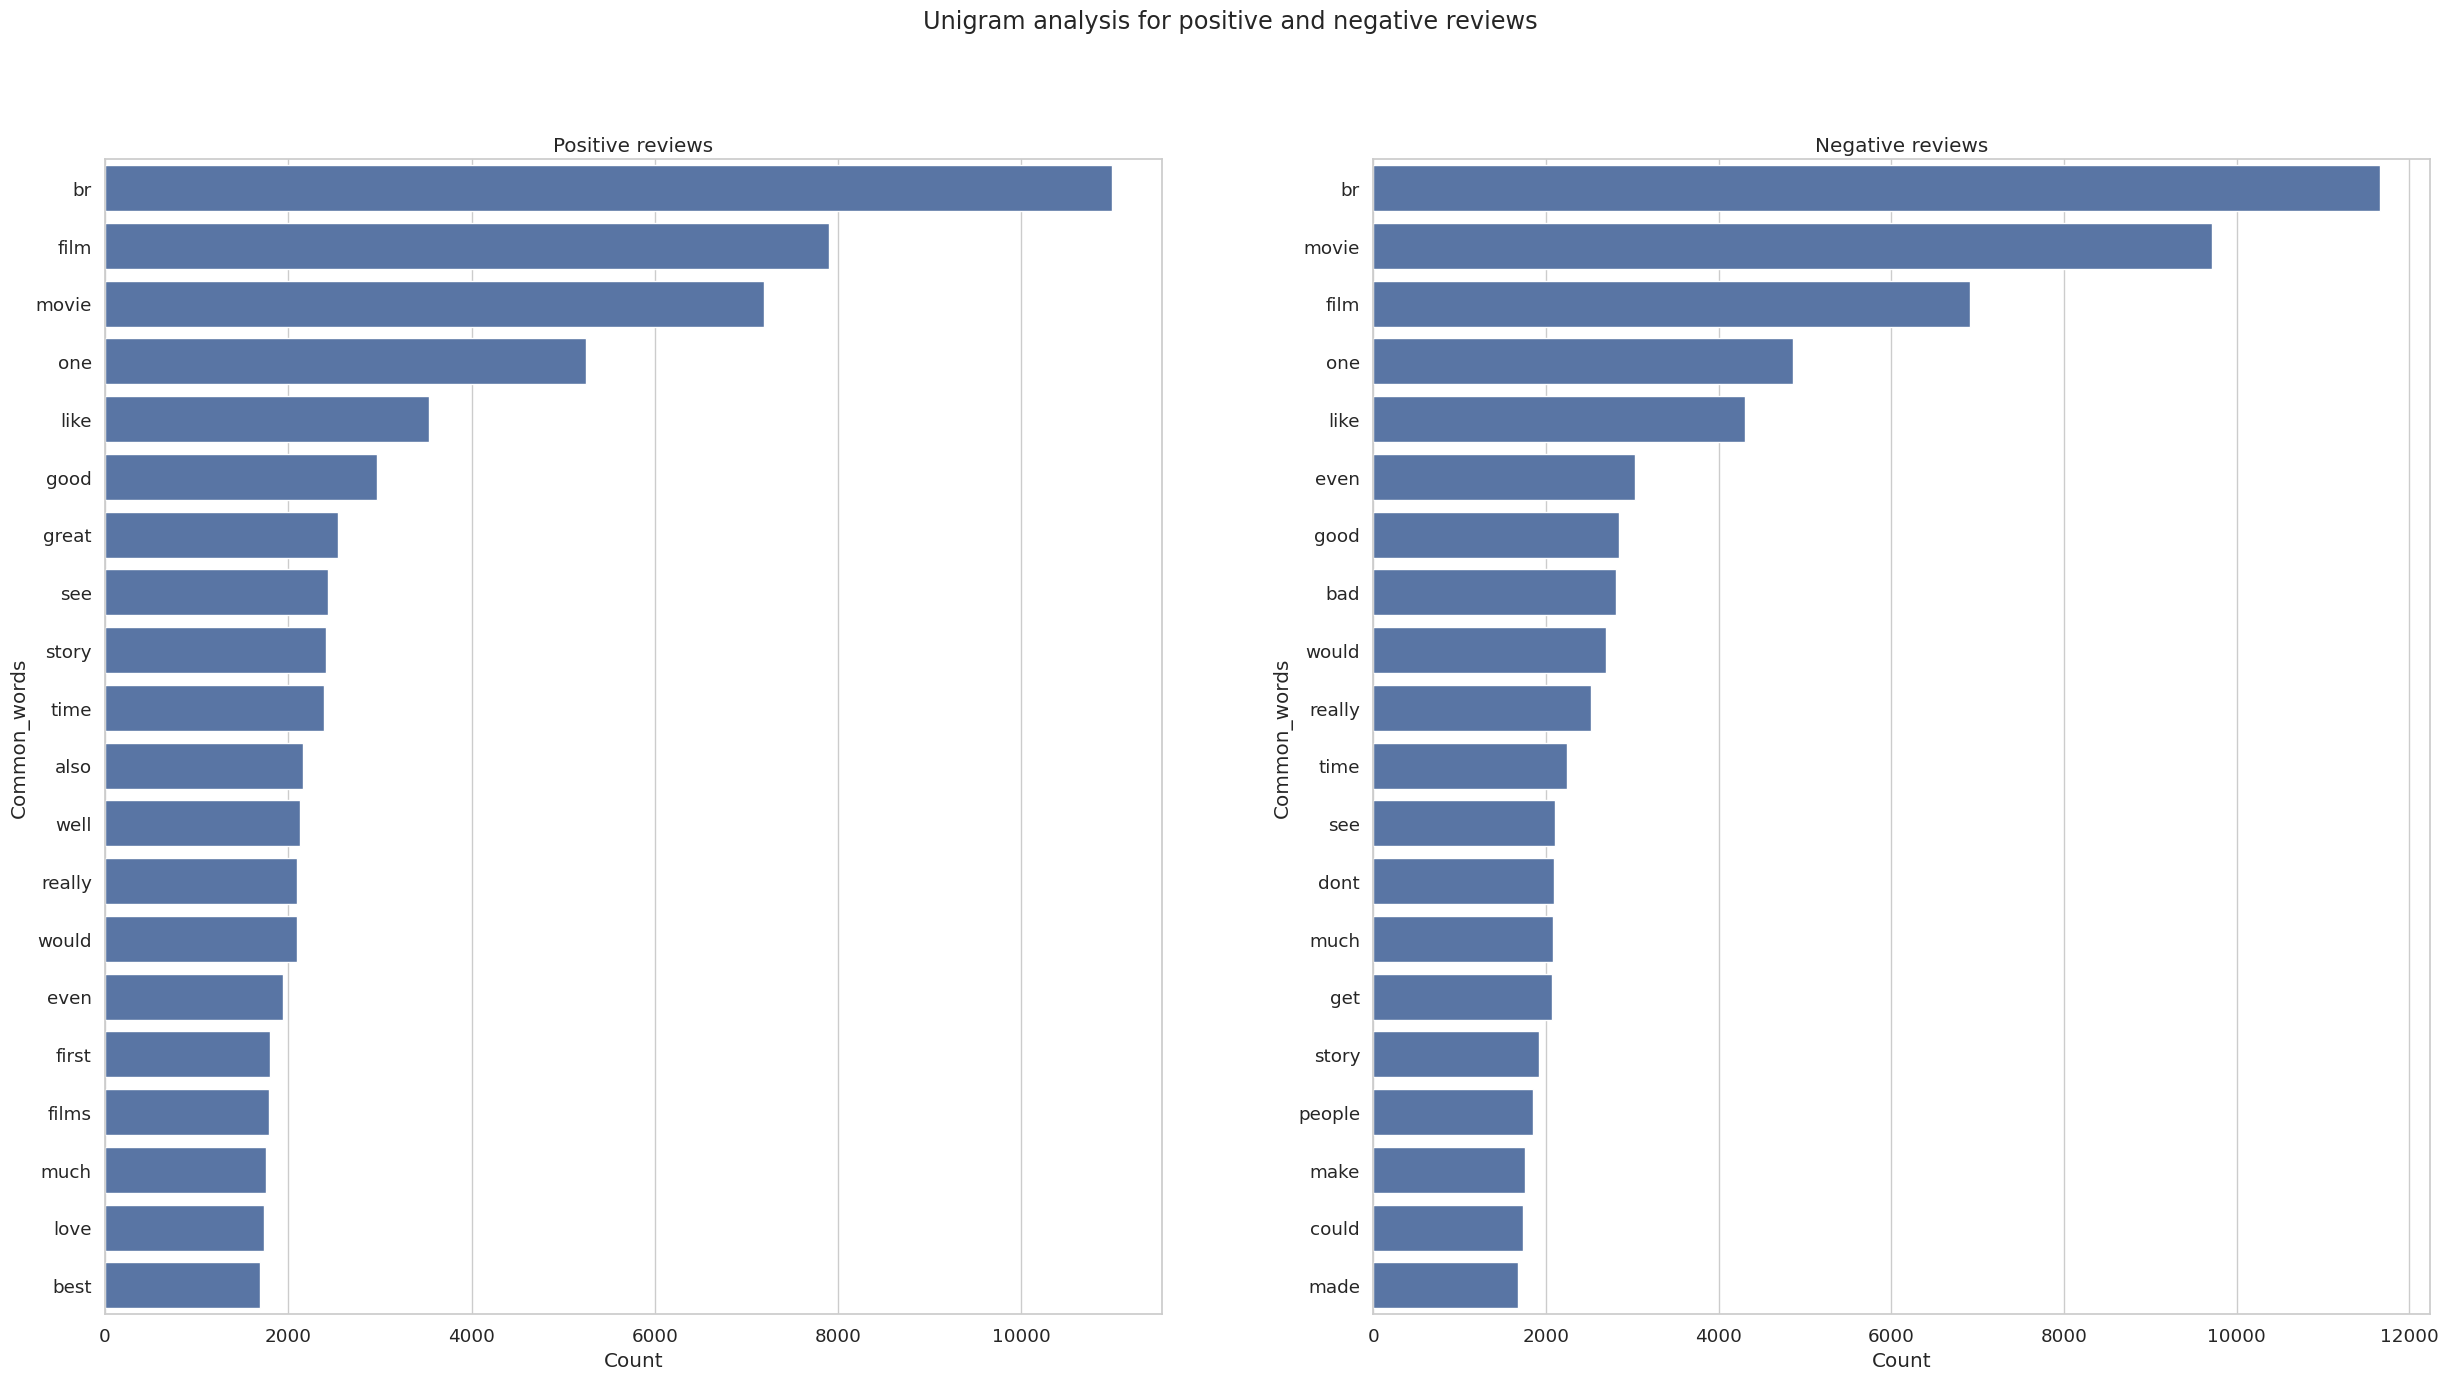

In [43]:
#display showing count of unigram analysis for pos and neg reviews
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))
uni_positive = get_ngrams(positive_data,20,1)
uni_positive = dict(uni_positive)
temp = pd.DataFrame(list(uni_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive reviews')
uni_negative = get_ngrams(negative_data,20,1)
uni_negative = dict(uni_negative)
temp = pd.DataFrame(list(uni_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative reviews')
fig.suptitle('Unigram analysis for positive and negative reviews')
plt.show()

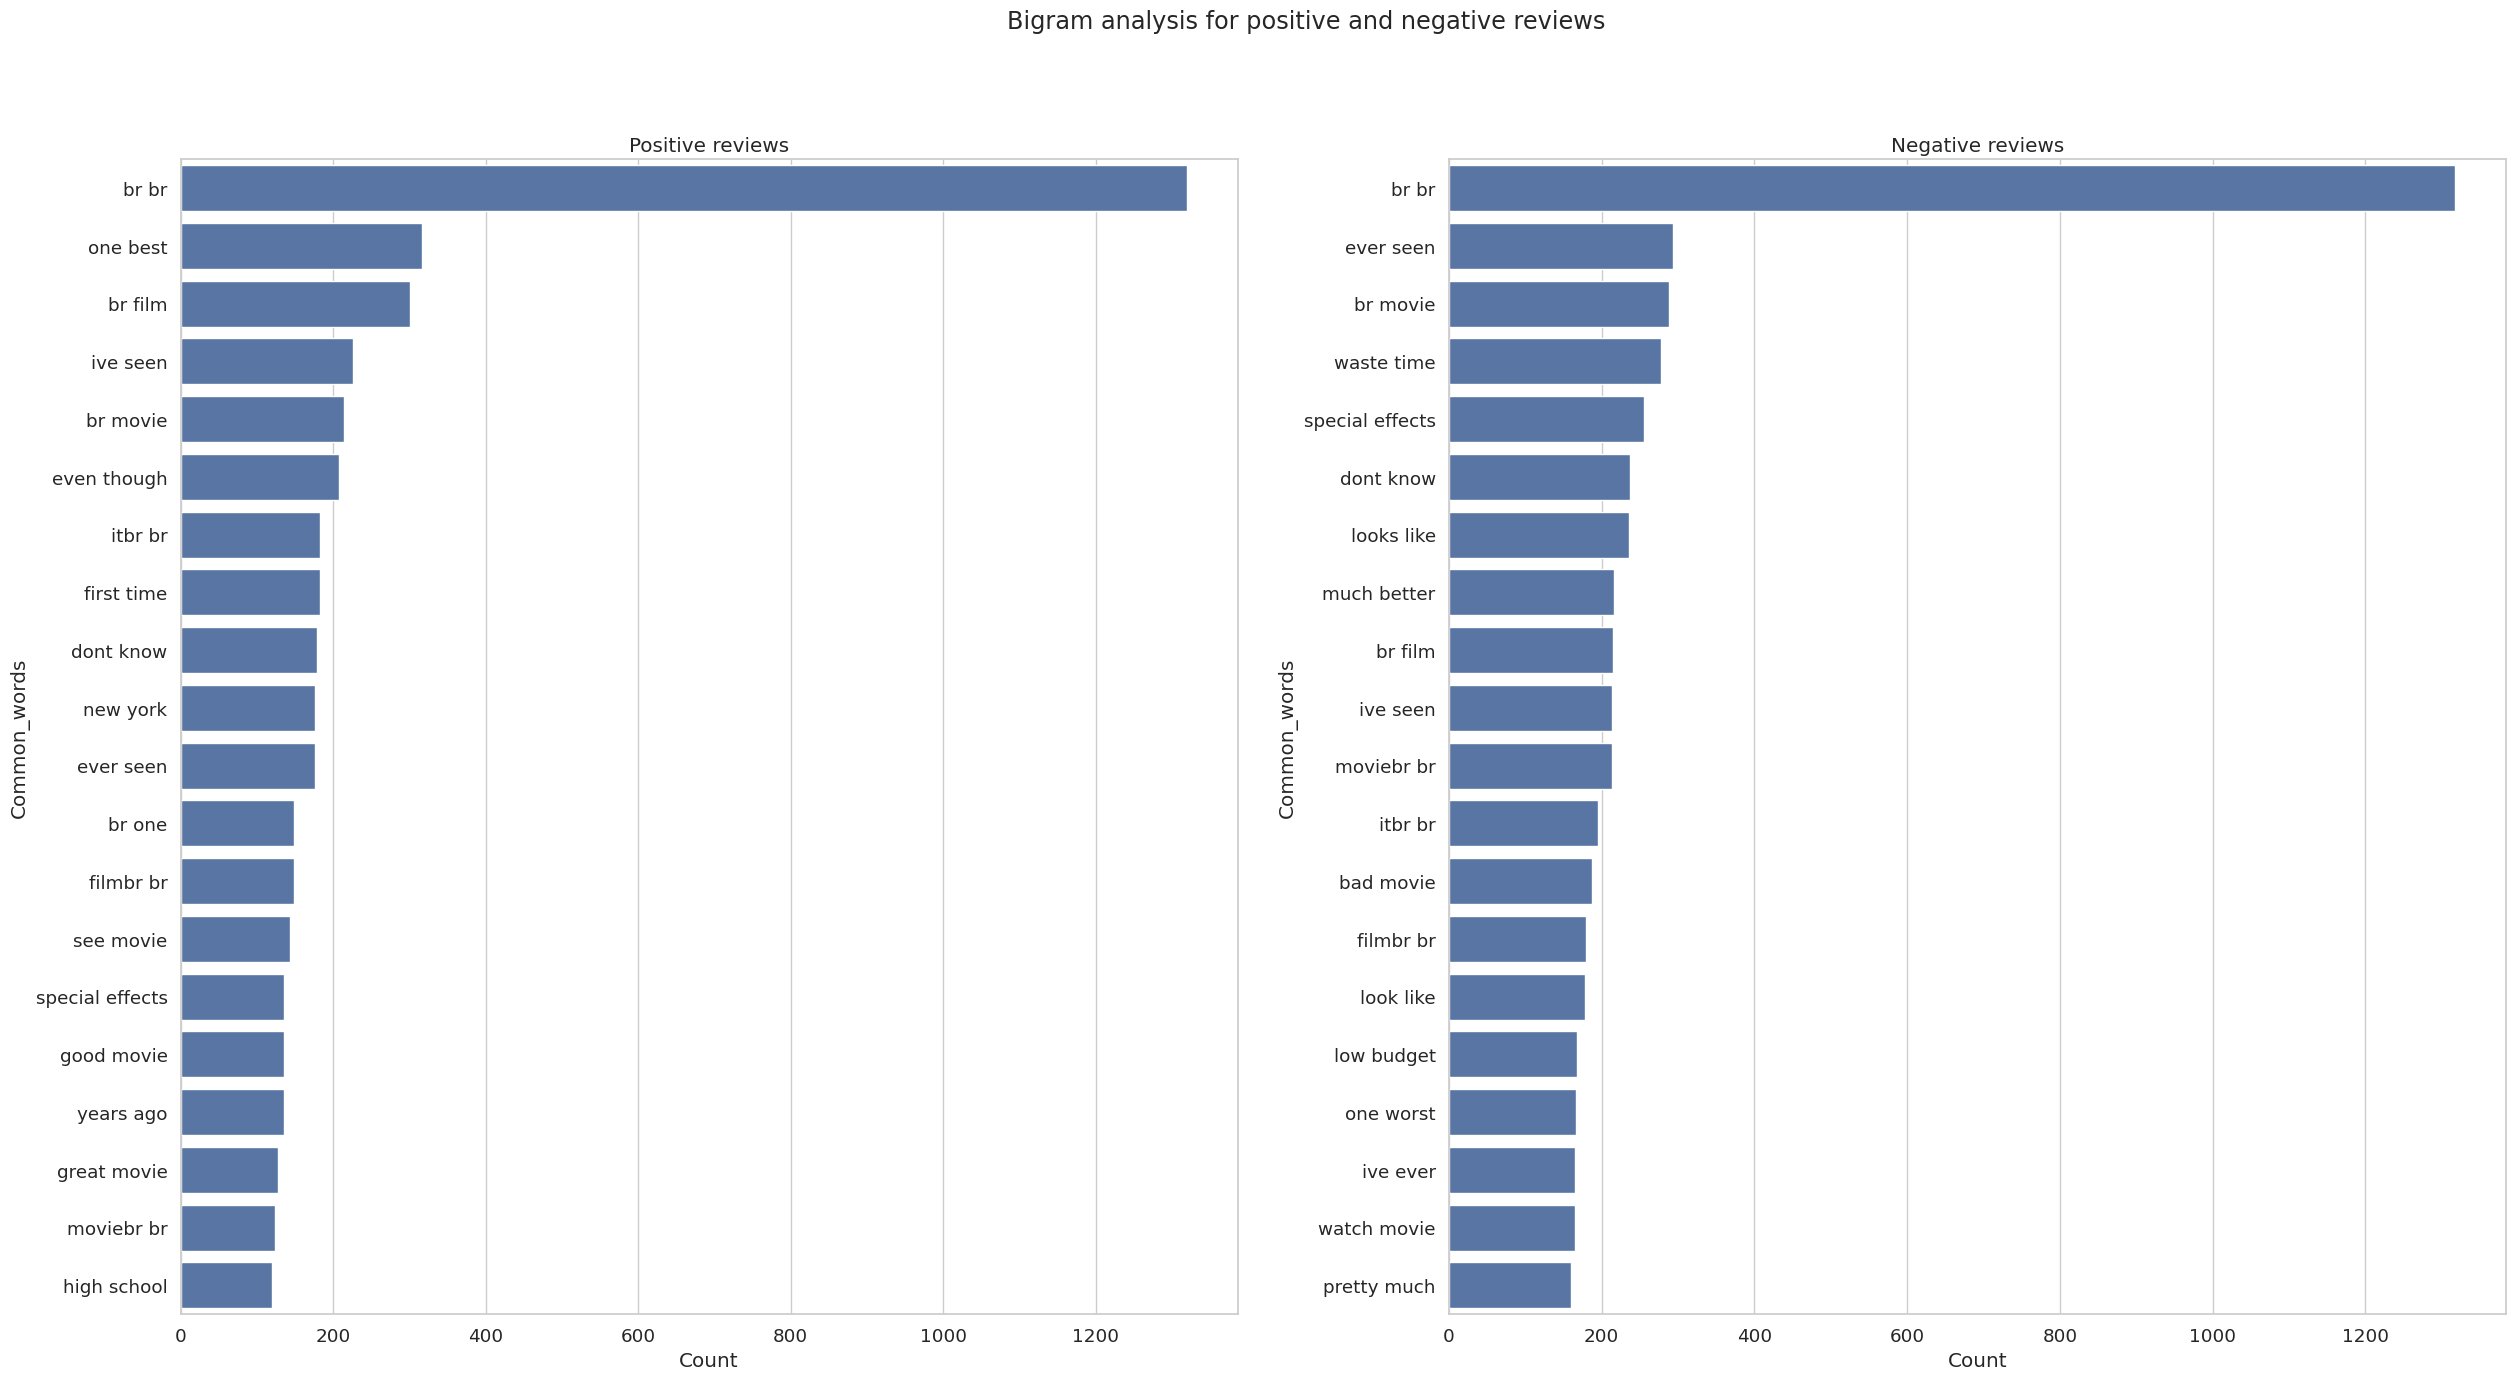

In [44]:
#display showing count of bigram analysis for pos and neg reviews
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))
bi_positive = get_ngrams(positive_data,20,2)
bi_positive = dict(bi_positive)
temp = pd.DataFrame(list(bi_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive reviews')
bi_negative = get_ngrams(negative_data,20,2)
bi_negative = dict(bi_negative)
temp = pd.DataFrame(list(bi_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative reviews')
fig.suptitle('Bigram analysis for positive and negative reviews')
plt.show()

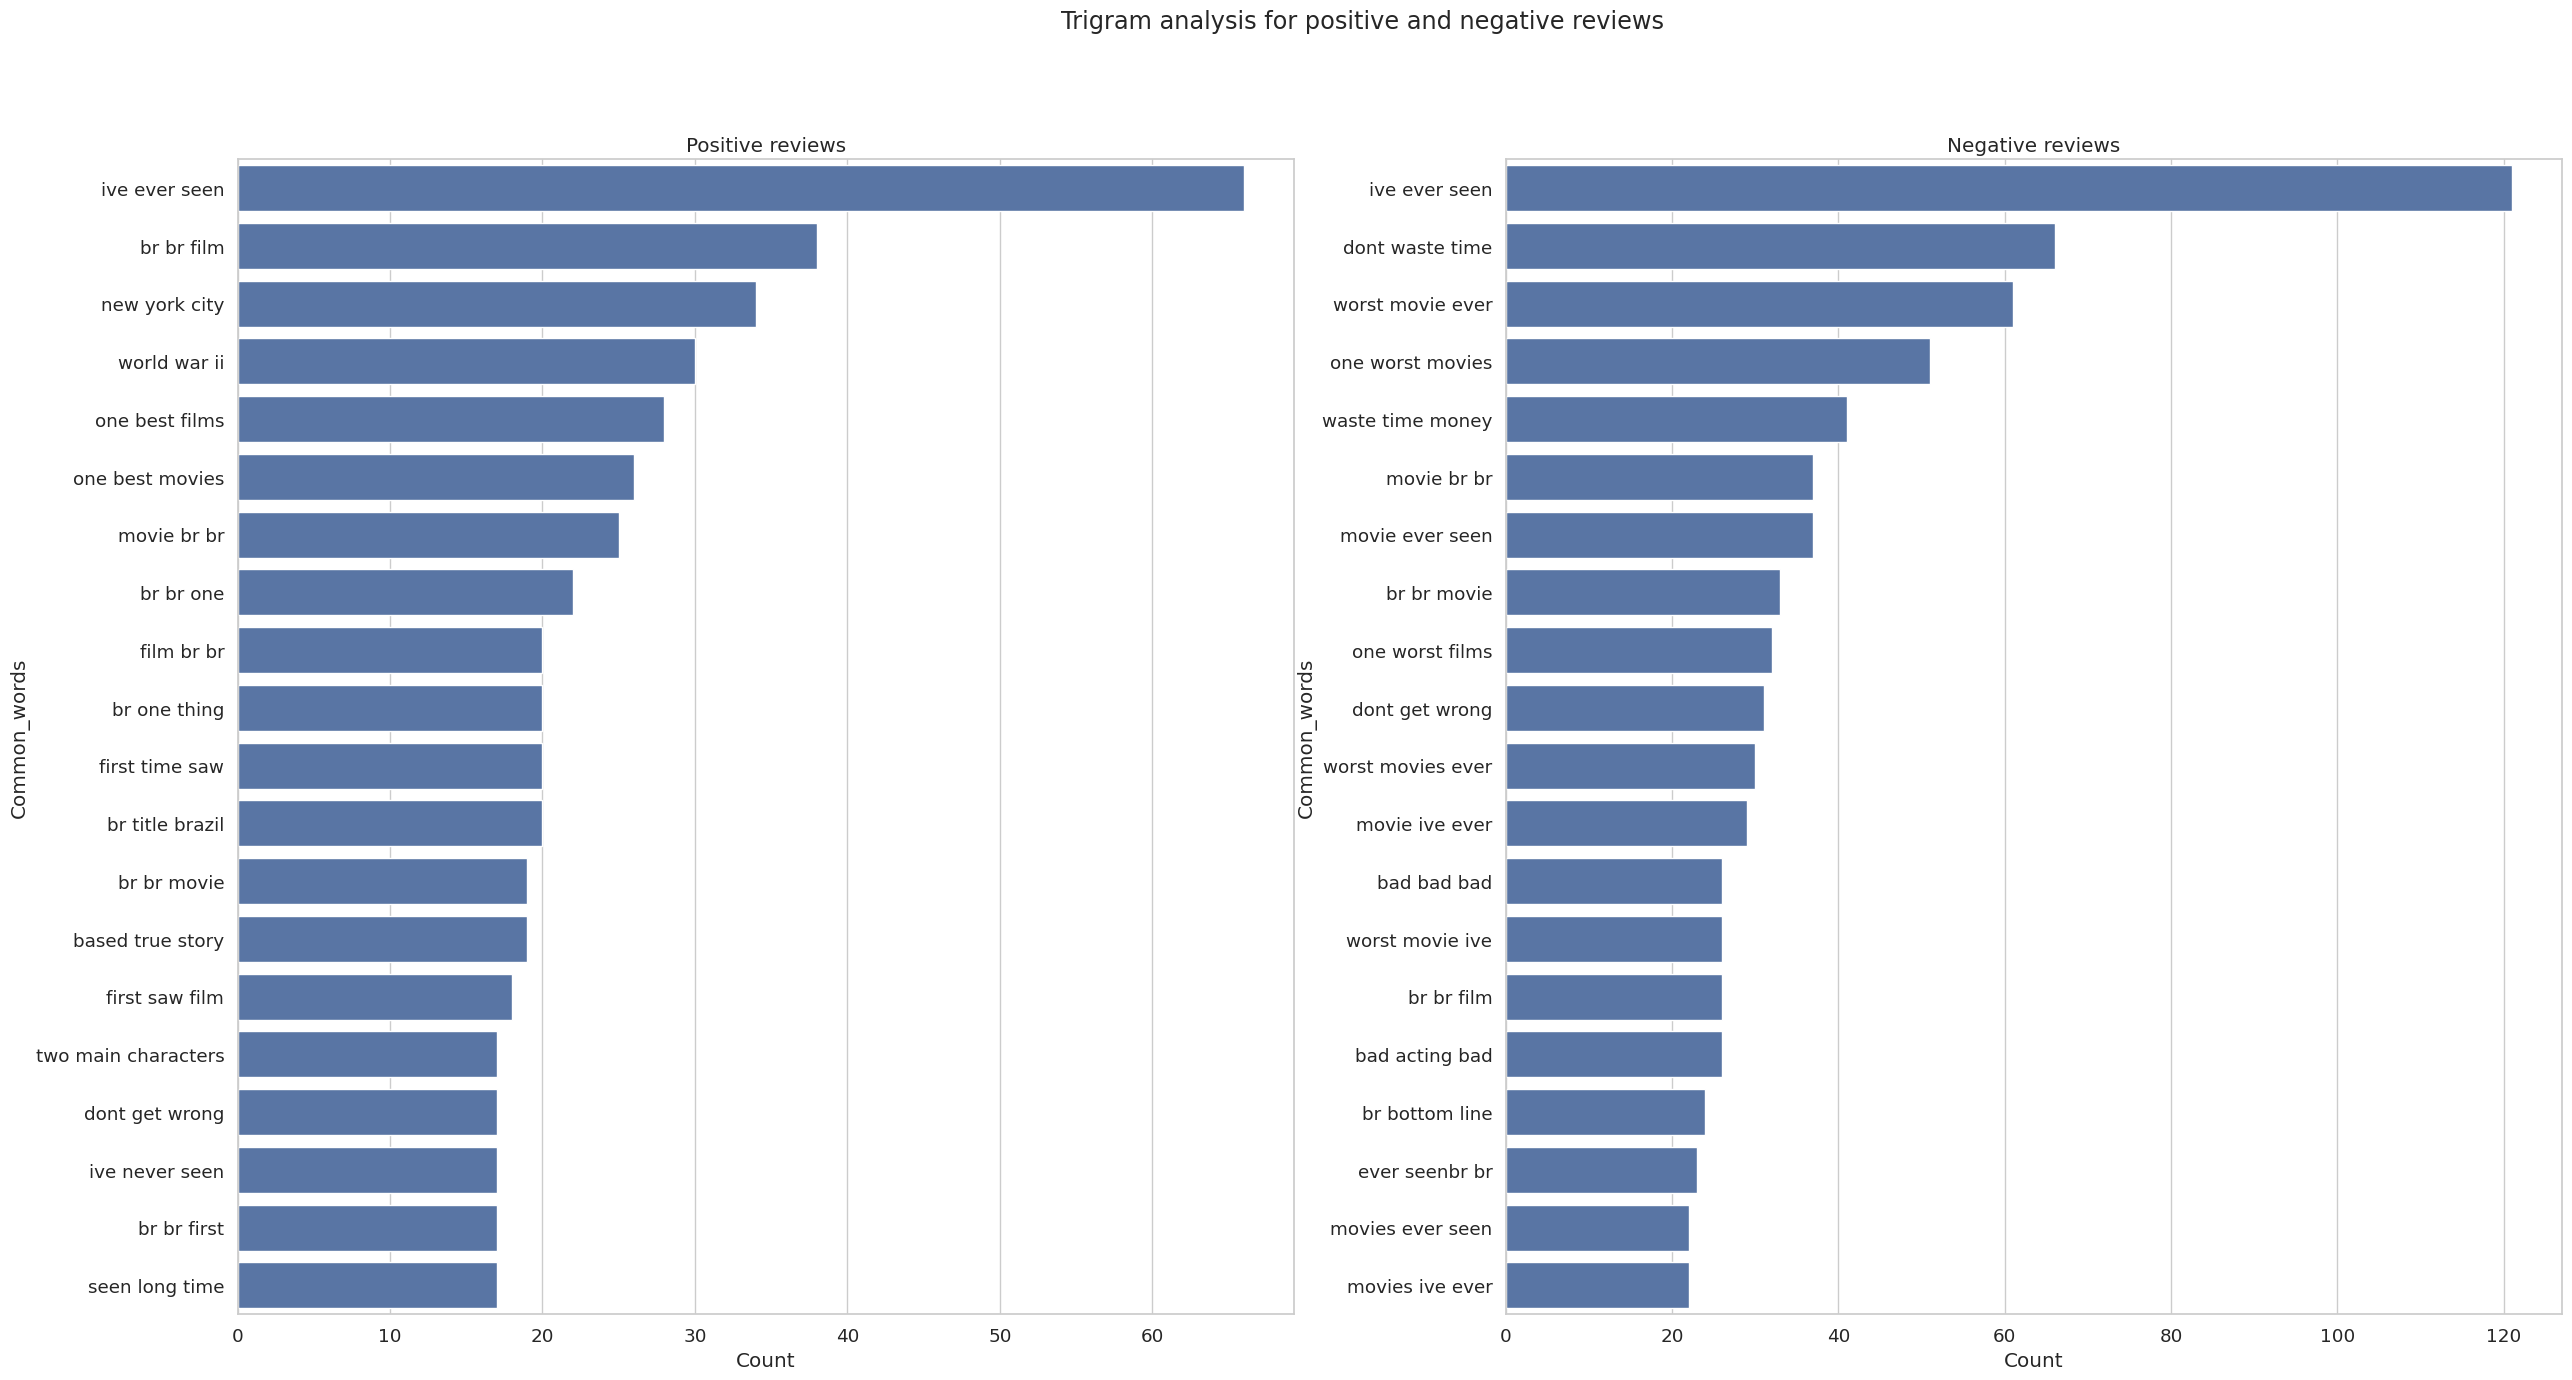

In [45]:
#display showing count for trigram analysis for pos and neg reviews
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))
tri_positive = get_ngrams(positive_data,20,3)
tri_positive = dict(tri_positive)
temp = pd.DataFrame(list(tri_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive reviews')
tri_negative = get_ngrams(negative_data,20,3)
tri_negative = dict(tri_negative)
temp = pd.DataFrame(list(tri_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative reviews')
fig.suptitle('Trigram analysis for positive and negative reviews')
plt.show()

In [46]:
#display of first five rows after EDA
df.head()

,review,sentiment
33553,really liked summerslam due look arena curtain...,1
9427,many television shows appeal quite many differ...,1
199,film quickly gets major chase scene ever incre...,0
12447,jane austen would definitely approve onebr br ...,1
39489,expectations somewhat high went see movie thou...,0


# **Traditional Models**

####**SVM and NB**

In [47]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42, stratify=df['sentiment'])

In [48]:
# --------------------- Traditional Models: SVM and Naive Bayes ---------------------

# TF-IDF Vectorization for traditional models
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Initialize a dictionary to store results
results = {}

# Train and evaluate SVM model
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)

results['SVM'] = {
    "Accuracy": accuracy_score(y_test, y_pred_svm),
    "Precision": precision_score(y_test, y_pred_svm),
    "Recall": recall_score(y_test, y_pred_svm),
    "F1-Score": f1_score(y_test, y_pred_svm)
}

# Train and evaluate Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)

results['Naive Bayes'] = {
    "Accuracy": accuracy_score(y_test, y_pred_nb),
    "Precision": precision_score(y_test, y_pred_nb),
    "Recall": recall_score(y_test, y_pred_nb),
    "F1-Score": f1_score(y_test, y_pred_nb)
}



#**Large Language Models**

###**BERT**

In [49]:
# Load BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Tokenize the dataset for BERT
def tokenize_data(texts):
    return bert_tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors='pt')

# --------------------- Fine-Tuning BERT ---------------------
# Prepare datasets for BERT
train_encodings_bert = tokenize_data(X_train.tolist())
test_encodings_bert = tokenize_data(X_test.tolist())

# Create a custom dataset class for BERT
class IMDBDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create training and testing datasets for BERT
train_dataset_bert = IMDBDataset(train_encodings_bert, y_train.to_numpy())
test_dataset_bert = IMDBDataset(test_encodings_bert, y_test.to_numpy())

# Define training arguments for BERT
training_args_bert = TrainingArguments(
    output_dir='./results_bert',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_bert',
    logging_steps=10,
    evaluation_strategy="epoch",
)

# Initialize Trainer for BERT
trainer_bert = Trainer(
    model=bert_model,
    args=training_args_bert,
    train_dataset=train_dataset_bert,
    eval_dataset=test_dataset_bert,
)

# Fine-tune the BERT model
trainer_bert.train()

# Evaluate the BERT model
trainer_bert.evaluate()

# Make predictions using BERT
predictions_bert = trainer_bert.predict(test_dataset_bert)
preds_bert = np.argmax(predictions_bert.predictions, axis=1)

# Add BERT results to the results dictionary
results['BERT'] = {
    "Accuracy": accuracy_score(y_test, preds_bert),
    "Precision": precision_score(y_test, preds_bert),
    "Recall": recall_score(y_test, preds_bert),
    "F1-Score": f1_score(y_test, preds_bert)
}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


<ipython-input-49-7ab4cba0e704>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,0.429700,0.422930
2,0.340000,0.350350
3,0.014100,0.491703


<ipython-input-49-7ab4cba0e704>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-49-7ab4cba0e704>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-49-7ab4cba0e704>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


##**FLAN-T5**

In [50]:
# --------------------- Fine-Tuning FLAN-T5 ---------------------

# Load FLAN-T5 tokenizer and model
flan_t5_tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-small")
flan_t5_model = T5ForSequenceClassification.from_pretrained("google/flan-t5-small", num_labels=2)

# Tokenize the dataset for FLAN-T5
def tokenize_data_flan_t5(texts):
    return flan_t5_tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors='pt')

# Prepare datasets for FLAN-T5
train_encodings_flan_t5 = tokenize_data_flan_t5(X_train.tolist())
test_encodings_flan_t5 = tokenize_data_flan_t5(X_test.tolist())

# Create training and testing datasets for FLAN-T5
train_dataset_flan_t5 = IMDBDataset(train_encodings_flan_t5, y_train.to_numpy())
test_dataset_flan_t5 = IMDBDataset(test_encodings_flan_t5, y_test.to_numpy())

# Define training arguments for FLAN-T5
training_args_flan_t5 = TrainingArguments(
    output_dir='./results_flan_t5',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_flan_t5',
    logging_steps=10,
    evaluation_strategy="epoch",
)

# Initialize Trainer for FLAN-T5
trainer_flan_t5 = Trainer(
    model=flan_t5_model,
    args=training_args_flan_t5,
    train_dataset=train_dataset_flan_t5,
    eval_dataset=test_dataset_flan_t5,
)

# Fine-tune the FLAN-T5 model
trainer_flan_t5.train()

# Evaluate the FLAN-T5 model
trainer_flan_t5.evaluate()


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at google/flan-t5-small and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-49-7ab4cba0e704>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,0.386600,0.368347
2,0.658000,0.352404
3,0.275700,0.442741


<ipython-input-49-7ab4cba0e704>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-49-7ab4cba0e704>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-49-7ab4cba0e704>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-49-7ab4cba0e704>:21: UserWarning: To copy construct fro

{'eval_loss': 0.4427412152290344,
 'eval_runtime': 10.3307,
 'eval_samples_per_second': 193.598,
 'eval_steps_per_second': 24.2,
 'epoch': 3.0}

In [51]:
# Make predictions using FLAN-T5
predictions_flan_t5 = trainer_flan_t5.predict(test_dataset_flan_t5)

# Process predictions to extract logits
logits = predictions_flan_t5.predictions

# Handle cases where predictions are nested or contain sequences
if isinstance(logits, tuple):
    logits = logits[0]


logits = np.array(logits)

# Get predicted class labels
preds_flan_t5 = np.argmax(logits, axis=1)

# Add FLAN-T5 results to the results dictionary
results['FLAN-T5'] = {
    "Accuracy": accuracy_score(y_test, preds_flan_t5),
    "Precision": precision_score(y_test, preds_flan_t5),
    "Recall": recall_score(y_test, preds_flan_t5),
    "F1-Score": f1_score(y_test, preds_flan_t5)
}

<ipython-input-49-7ab4cba0e704>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [52]:
# --------------------- Fine-Tuning GPT-2 ---------------------

from transformers import GPT2Tokenizer, GPT2ForSequenceClassification

# Load GPT-2 tokenizer and model
gpt_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt_model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=2)

# Set the padding token to the EOS token
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token
gpt_model.config.pad_token_id = gpt_tokenizer.eos_token_id

# Tokenize the dataset for GPT-2
def tokenize_data_gpt(texts):
    return gpt_tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors='pt')

# Prepare datasets for GPT-2
train_encodings_gpt = tokenize_data_gpt(X_train.tolist())
test_encodings_gpt = tokenize_data_gpt(X_test.tolist())

# Create training and testing datasets for GPT-2
train_dataset_gpt = IMDBDataset(train_encodings_gpt, y_train.to_numpy())
test_dataset_gpt = IMDBDataset(test_encodings_gpt, y_test.to_numpy())

# Define training arguments for GPT-2
training_args_gpt = TrainingArguments(
    output_dir='./results_gpt',
    num_train_epochs=3,
    per_device_train_batch_size=1,  # Set batch size to 1 if there are still issues
    per_device_eval_batch_size=1,  # Set batch size to 1 to avoid issues with padding
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_gpt',
    logging_steps=10,
    eval_strategy="epoch",
)

# Initialize Trainer for GPT-2
trainer_gpt = Trainer(
    model=gpt_model,
    args=training_args_gpt,
    train_dataset=train_dataset_gpt,
    eval_dataset=test_dataset_gpt,
)

# Fine-tune the GPT-2 model
trainer_gpt.train()

# Evaluate the GPT-2 model
trainer_gpt.evaluate()

# Make predictions using GPT-2
predictions_gpt = trainer_gpt.predict(test_dataset_gpt)
preds_gpt = np.argmax(predictions_gpt.predictions, axis=1)

# Add GPT-2 results to the results dictionary
results['GPT-2'] = {
    "Accuracy": accuracy_score(y_test, preds_gpt),
    "Precision": precision_score(y_test, preds_gpt),
    "Recall": recall_score(y_test, preds_gpt),
    "F1-Score": f1_score(y_test, preds_gpt)
}


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-49-7ab4cba0e704>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,1.254300,1.171292
2,0.643100,1.171075
3,0.000200,1.284294


<ipython-input-49-7ab4cba0e704>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-49-7ab4cba0e704>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-49-7ab4cba0e704>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-49-7ab4cba0e704>:21: UserWarning: To copy construct fro

In [53]:
# --------------------- Display Results ---------------------

import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(results)

{   'BERT': {   'Accuracy': 0.8785,
                'F1-Score': 0.8757033248081841,
                'Precision': 0.9039070749736009,
                'Recall': 0.8492063492063492},
    'FLAN-T5': {   'Accuracy': 0.8615,
                   'F1-Score': 0.859746835443038,
                   'Precision': 0.8779731127197518,
                   'Recall': 0.8422619047619048},
    'GPT-2': {   'Accuracy': 0.828,
                 'F1-Score': 0.823045267489712,
                 'Precision': 0.8547008547008547,
                 'Recall': 0.7936507936507936},
    'Naive Bayes': {   'Accuracy': 0.8415,
                       'F1-Score': 0.8440727988194786,
                       'Precision': 0.8370731707317073,
                       'Recall': 0.8511904761904762},
    'SVM': {   'Accuracy': 0.8575,
               'F1-Score': 0.8607718612603811,
               'Precision': 0.8479307025986526,
               'Recall': 0.8740079365079365}}


Shape of extracted FLAN-T5 logits: (2000, 2)


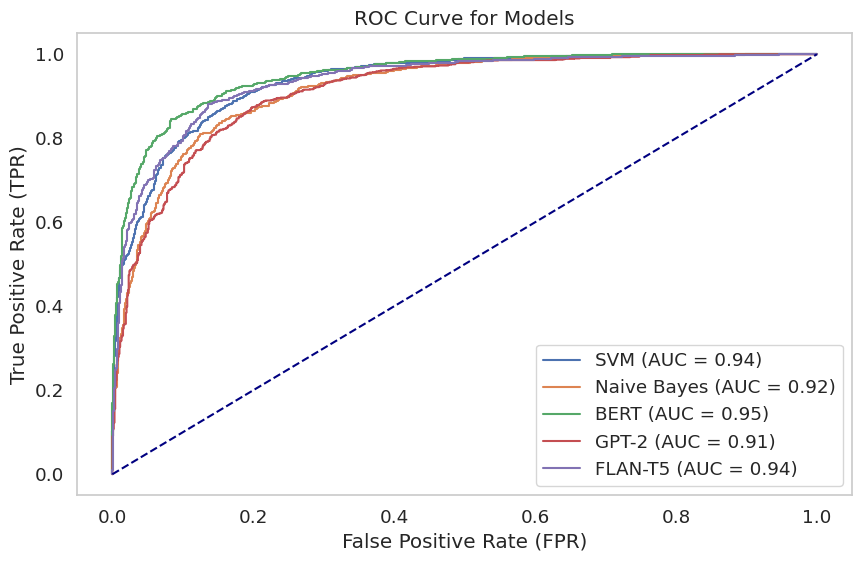

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch

# Function to plot ROC curve
def plot_roc_curve(fpr, tpr, roc_auc, model_name):
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Initialize a plot for the ROC curves
plt.figure(figsize=(10, 6))

# Traditional Models
# 1. SVM
y_pred_prob_svm = svm.decision_function(X_test_tfidf)  # Get decision scores for SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plot_roc_curve(fpr_svm, tpr_svm, roc_auc_svm, "SVM")

# 2. Naive Bayes
y_pred_prob_nb = nb.predict_proba(X_test_tfidf)[:, 1]  # Get probabilities for positive class
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_prob_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)
plot_roc_curve(fpr_nb, tpr_nb, roc_auc_nb, "Naive Bayes")

# Transformer Models
# 3. BERT
predictions_bert_prob = torch.nn.functional.softmax(torch.tensor(predictions_bert.predictions), dim=1)[:, 1].numpy()
fpr_bert, tpr_bert, _ = roc_curve(y_test, predictions_bert_prob)
roc_auc_bert = auc(fpr_bert, tpr_bert)
plot_roc_curve(fpr_bert, tpr_bert, roc_auc_bert, "BERT")

# 4. GPT-2
predictions_gpt_prob = torch.nn.functional.softmax(torch.tensor(predictions_gpt.predictions), dim=1)[:, 1].numpy()
fpr_gpt, tpr_gpt, _ = roc_curve(y_test, predictions_gpt_prob)
roc_auc_gpt = auc(fpr_gpt, tpr_gpt)
plot_roc_curve(fpr_gpt, tpr_gpt, roc_auc_gpt, "GPT-2")

# 5. FLAN-T5
# # Debugging: Inspect predictions_flan_t5 structure
# print("FLAN-T5 predictions tuple structure:", type(predictions_flan_t5.predictions))
# print("Contents of FLAN-T5 predictions tuple:", predictions_flan_t5.predictions)

# Assuming predictions_flan_t5.predictions is a tuple where the first element contains logits
logits_flan_t5 = predictions_flan_t5.predictions[0]
print("Shape of extracted FLAN-T5 logits:", logits_flan_t5.shape)

# If logits have more than two dimensions, reduce them appropriately
if len(logits_flan_t5.shape) > 2:
    logits_flan_t5 = logits_flan_t5[:, 0, :]  # Example: Take first token's logits

# Apply softmax to get probabilities
predictions_flan_t5_prob = torch.nn.functional.softmax(torch.tensor(logits_flan_t5), dim=1)[:, 1].numpy()

# Compute ROC and AUC for FLAN-T5
fpr_flan_t5, tpr_flan_t5, _ = roc_curve(y_test, predictions_flan_t5_prob)
roc_auc_flan_t5 = auc(fpr_flan_t5, tpr_flan_t5)

# Plot the FLAN-T5 ROC curve
plot_roc_curve(fpr_flan_t5, tpr_flan_t5, roc_auc_flan_t5, "FLAN-T5")

# Finalize the plot
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line for random chance
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Models')
plt.legend(loc="lower right")
plt.grid()
plt.show()


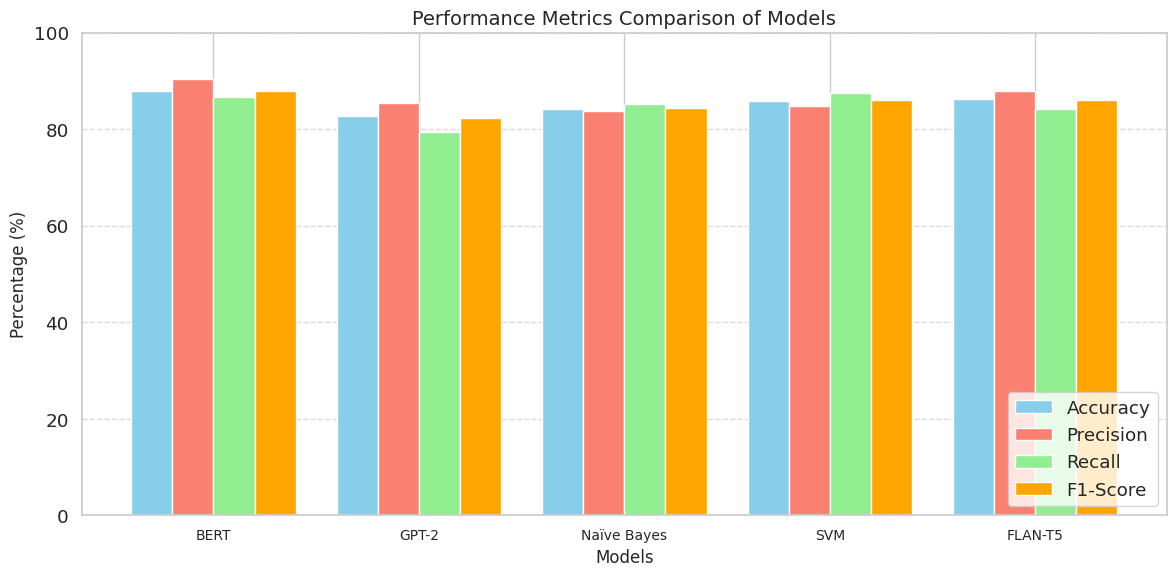

In [60]:
#Visualize performance metrics data in bar chart
# Performance metrics data
models = ['BERT', 'GPT-2', 'Naïve Bayes', 'SVM', 'FLAN-T5']
accuracy = [87.85, 82.8, 84.15, 85.75, 86.15]
precision = [90.39, 85.47, 83.70, 84.79, 87.79]
recall = [86.71, 79.36, 85.11, 87.40, 84.22]
f1_score = [87.79, 82.30, 84.40, 86.07, 85.97]

# Create the figure and axes
x = np.arange(len(models))  # Create x-axis positions
width = 0.2  # Width of each bar

# Plot each metric
plt.figure(figsize=(12, 6))
plt.bar(x - 1.5 * width, accuracy, width, label='Accuracy', color='skyblue')
plt.bar(x - 0.5 * width, precision, width, label='Precision', color='salmon')
plt.bar(x + 0.5 * width, recall, width, label='Recall', color='lightgreen')
plt.bar(x + 1.5 * width, f1_score, width, label='F1-Score', color='orange')

# Add labels, title, and legend
plt.xlabel('Models', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.title('Performance Metrics Comparison of Models', fontsize=14)
plt.xticks(x, models, fontsize=10)
plt.legend(loc='lower right')
plt.ylim(0, 100)  # Set y-axis limit to 100 for percentage values
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


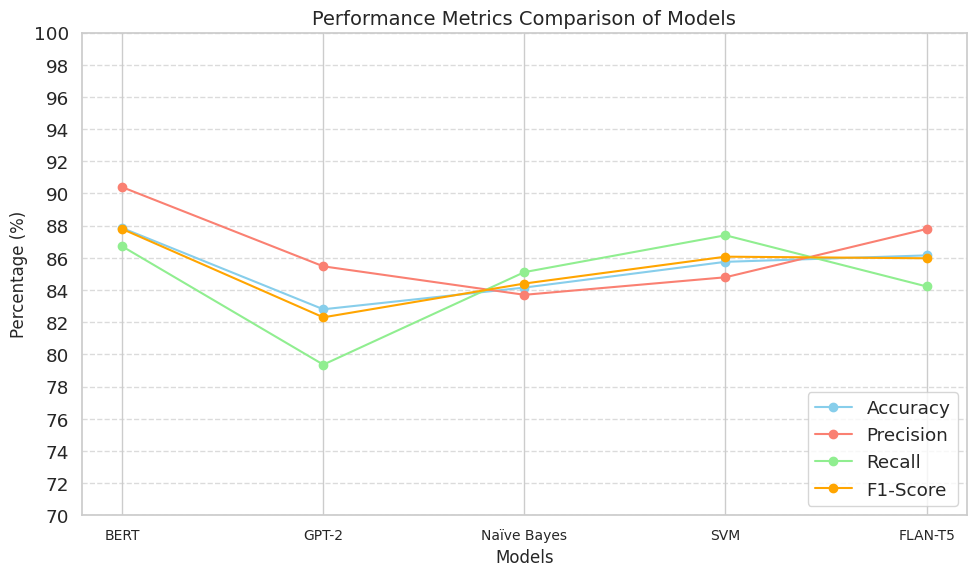

In [61]:
#visualize performance metrics in line chart
# Performance metrics data
models = ['BERT', 'GPT-2', 'Naïve Bayes', 'SVM', 'FLAN-T5']
accuracy = [87.85, 82.8, 84.15, 85.75, 86.15]
precision = [90.39, 85.47, 83.70, 84.79, 87.79]
recall = [86.71, 79.36, 85.11, 87.40, 84.22]
f1_score = [87.79, 82.30, 84.40, 86.07, 85.97]


# Plot line graph for performance metrics with adjusted scale
plt.figure(figsize=(10, 6))

# Plot each metric as a line
plt.plot(models, accuracy, marker='o', label='Accuracy', color='skyblue')
plt.plot(models, precision, marker='o', label='Precision', color='salmon')
plt.plot(models, recall, marker='o', label='Recall', color='lightgreen')
plt.plot(models, f1_score, marker='o', label='F1-Score', color='orange')

# Add labels, title, and legend
plt.xlabel('Models', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.title('Performance Metrics Comparison of Models', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(np.arange(70, 101, 2))  # Adjust y-axis scale for better display
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


In [62]:
import torch

def classify_text(text, models, tfidf_vectorizer, bert_tokenizer, gpt_tokenizer, flan_t5_tokenizer):
    """Classifies input text using various models (SVM, Naive Bayes, BERT, GPT-2, FLAN-T5) and returns the predictions."""
    predictions = {}
    label_map = {0: "Negative", 1: "Positive"}

    # SVM and Naive Bayes with TF-IDF Vectorization
    try:
        text_tfidf = tfidf_vectorizer.transform([text])
        predictions['SVM'] = label_map[models['SVM'].predict(text_tfidf)[0]]
        predictions['Naive Bayes'] = label_map[models['Naive Bayes'].predict(text_tfidf)[0]]
    except Exception as e:
        print(f"Error during traditional model classification: {e}")

    # Check device for BERT, GPT-2, and FLAN-T5
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # BERT Tokenization and Prediction
    try:
        encoding = bert_tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)
        models['BERT'].to(device)
        with torch.no_grad():
            output = models['BERT'](input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])
        predictions['BERT'] = label_map[torch.argmax(output.logits, dim=1).item()]
    except Exception as e:
        print(f"Error during BERT classification: {e}")

    # GPT-2 Tokenization and Prediction
    try:
        encoding = gpt_tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)
        models['GPT-2'].to(device)
        with torch.no_grad():
            output = models['GPT-2'](input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])
        predictions['GPT-2'] = label_map[torch.argmax(output.logits, dim=1).item()]
    except Exception as e:
        print(f"Error during GPT-2 classification: {e}")

    # FLAN-T5 Tokenization and Prediction
    try:
        flan_input = flan_t5_tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)
        models['FLAN-T5'].to(device)
        with torch.no_grad():
            output = models['FLAN-T5'](input_ids=flan_input['input_ids'], attention_mask=flan_input['attention_mask'])
        predictions['FLAN-T5'] = label_map[torch.argmax(output.logits, dim=1).item()]
    except Exception as e:
        print(f"Error during FLAN-T5 classification: {e}")

    return predictions

# Example usage of classify_text
models = {
    'SVM': svm,
    'Naive Bayes': nb,
    'BERT': bert_model,
    'GPT-2': gpt_model,
    'FLAN-T5': flan_t5_model
}

# Sample input text
text_to_classify = "This is the best movie of my life."

# Classify the text
classification_results = classify_text(
    text_to_classify,
    models,
    tfidf_vectorizer=tfidf,
    bert_tokenizer=bert_tokenizer,
    gpt_tokenizer=gpt_tokenizer,
    flan_t5_tokenizer=flan_t5_tokenizer
)
print('input text: This is the best movie of my life')
print("Classification Results for the input text:")
print(classification_results)


input text: This is the best movie of my life
Classification Results for the input text:
{'SVM': 'Positive', 'Naive Bayes': 'Positive', 'BERT': 'Positive', 'GPT-2': 'Positive', 'FLAN-T5': 'Positive'}


In [63]:
from transformers import BertTokenizer, BertForSequenceClassification

# Assuming `model` is your trained BERT model
# And `tokenizer` is your tokenizer
model_name_or_path = "bert-base-uncased"

# Save the model
bert_model.save_pretrained("saved_bert_model")

# Save the tokenizer
bert_tokenizer.save_pretrained("saved_bert_model")

('saved_bert_model/tokenizer_config.json',
 'saved_bert_model/special_tokens_map.json',
 'saved_bert_model/vocab.txt',
 'saved_bert_model/added_tokens.json')

In [64]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load the model
bert_model = BertForSequenceClassification.from_pretrained("saved_bert_model")

# Load the tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("saved_bert_model")
